# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [56]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [57]:
!nvidia-smi

Mon Dec  2 02:58:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              31W /  70W |    187MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [58]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'charles_dickens.txt'

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

# This is the output of the dataset including the size and number of unique characters:
# Dataset size (in characters): 270817
# Number of unique characters: 94
Number of sequences: 2708
Shape of X (sequences): (2708, 100)
Shape of y (targets): (2708,)

In [59]:
import requests
import numpy as np

# Function to download the file
def download_file(url, file_path):
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

# Function to load the dataset
def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Dataset
dataset = 'charles_dickens.txt'
download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/{dataset}', dataset)

# Load the dataset
raw_text = load_dataset(dataset)

# Print the first 1000 characters
print("First 1000 characters of the dataset:")
print(raw_text[:1000])

# Report the dataset size
dataset_size = len(raw_text)
print(f"\nDataset size (in characters): {dataset_size}")

# Report the number of unique characters
unique_characters = len(set(raw_text))
print(f"Number of unique characters: {unique_characters}")

# Data Prep
def clean_text(text):
    # Remove unwanted characters (e.g., newlines, multiple spaces, etc.)
    text = text.replace('\n', ' ').replace('\r', ' ').lower()
    return text

def tokenize_text(text, seq_length=100):
    # Tokenize text into characters (or words)
    chars = sorted(set(text))
    char_to_index = {char: index for index, char in enumerate(chars)}
    index_to_char = {index: char for char, index in char_to_index.items()}

    # Create sequences of fixed length
    sequences = []
    targets = []
    for i in range(0, len(text) - seq_length, seq_length):
        seq = text[i:i+seq_length]
        target = text[i+seq_length]
        sequences.append([char_to_index[char] for char in seq])
        targets.append(char_to_index[target])

    # Convert sequences and targets into numpy arrays
    X = np.array(sequences)
    y = np.array(targets)

    return X, y, char_to_index, index_to_char

# Clean the raw text
cleaned_text = clean_text(raw_text)

# Tokenize the cleaned text and create sequences
seq_length = 100  # Length of the sequences
X, y, char_to_index, index_to_char = tokenize_text(cleaned_text, seq_length)

print(f"Number of sequences: {len(X)}")
print(f"Shape of X (sequences): {X.shape}")
print(f"Shape of y (targets): {y.shape}")



First 1000 characters of the dataset:







<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  
  >



  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">

      <link rel="preload" href="https://github.githubassets.com/assets/global-banner-disable-f988792be49f.js" as="script" crossorigin>

  <link rel="preload" href="https://github.githubassets.com/assets/mona-sans-d1bf285e9b9b.woff2" as="font" type="font/woff2" crossorigin>


  <link cross

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Your code here
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Clean the text (convert to lowercase)
cleaned_text = raw_text.lower()  # Lowercase the entire text

# Fit the tokenizer on the cleaned text
tokenizer.fit_on_texts([cleaned_text])

# Convert the cleaned text into a sequence of numbers
sequences = tokenizer.texts_to_sequences([cleaned_text])[0]

# print details about tokenization process
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"First 100 tokens: {sequences[:100]}")  # Print the first 100 tokens
print(f"Index of OOV token: {tokenizer.word_index[OOV_TOKEN]}")

Vocabulary size: 5816
First 100 tokens: [1622, 459, 459, 1133, 874, 11, 52, 1134, 187, 11, 252, 260, 252, 11, 213, 260, 213, 11, 1135, 1623, 1136, 1624, 11, 1135, 10, 1625, 18, 1137, 80, 460, 461, 34, 10, 122, 678, 679, 31, 25, 15, 67, 27, 10, 122, 678, 679, 31, 25, 1138, 875, 27, 10, 122, 678, 679, 31, 25, 15, 1626, 1627, 1628, 27, 10, 122, 678, 679, 31, 25, 462, 1136, 875, 27, 10, 122, 1139, 31, 25, 15, 67, 27, 70, 10, 122, 1139, 31, 25, 1138, 875, 27, 10, 122, 1140, 31, 25, 15, 67, 27, 65, 304, 876, 877]
Index of OOV token: 1


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [61]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('0', 2), ('1', 3), ('quot', 4), ('75', 5), ('25', 6), ('2', 7), ('class', 8), ('3', 9), ('link', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [62]:
# Sequence length = 100
SEQ_LENGTH = 100

# Convert text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]  # Get the first (and only) sequence

# Generate the training sequences
X = []
y = []

# Initialize input_sequences and target_sequences as empty lists
input_sequences = []
target_sequences = []

for i in range(0, len(sequences) - SEQ_LENGTH, 1):
    input_seq = sequences[i : i + SEQ_LENGTH]
    target_seq = sequences[i + SEQ_LENGTH]
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

# Populate X and y using input_sequences and target_sequences
X = input_sequences  # Assign input_sequences to X
y = target_sequences # Assign target_sequences to y

print(f"Number of training sequences: {len(input_sequences)}")

Number of training sequences: 3627


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [63]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [1622, 459, 459, 1133, 874, 11, 52, 1134, 187, 11, 252, 260, 252, 11, 213, 260, 213, 11, 1135, 1623, 1136, 1624, 11, 1135, 10, 1625, 18, 1137, 80, 460, 461, 34, 10, 122, 678, 679, 31, 25, 15, 67, 27, 10, 122, 678, 679, 31, 25, 1138, 875, 27, 10, 122, 678, 679, 31, 25, 15, 1626, 1627, 1628, 27, 10, 122, 678, 679, 31, 25, 462, 1136, 875, 27, 10, 122, 1139, 31, 25, 15, 67, 27, 70, 10, 122, 1139, 31, 25, 1138, 875, 27, 10, 122, 1140, 31, 25, 15, 67, 27, 65, 304, 876, 877]
Target: 1629
Translated back to words: ['doctype', 'html', 'html', 'lang', 'en', 'data', 'color', 'mode', 'auto', 'data', 'light', 'theme', 'light', 'data', 'dark', 'theme', 'dark', 'data', 'a11y', 'animated', 'images', 'system', 'data', 'a11y', 'link', 'underlines', 'true', 'head', 'meta', 'charset', 'utf', '8', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'github', 'githubassets', 'com', 'link', 'rel', 'dns', 'prefetch', 'href', 'https', 'avatars', 'githubusercontent', 'com', 'link', 'rel', 'dns', 'prefe

And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [64]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure tokenizer is initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Remove OOV token
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (2901, 100)
y_train shape: (2901, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [65]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=SEQ_LENGTH),
    LSTM(units=128, return_sequences=False),
    Dense(units=VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

For the Loss function, I used sparse_categorical_crossentropy because the target tokens are represented as integers
For the Optimizer I used Adam because it adjusts the learning rate during training, making it efficient and effective for RNN models.
For the Metric I selected accuracy to measure how often the model correctly predicts the next word in the sequence.

In [66]:
from keras.optimizers import Adam

# Compile model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Check if model has layers before printing summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [67]:
# Verify shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Reshape y if necessary
y = y.reshape(-1)

# Train model for 5 epochs with batch size=128
history = model.fit(X, y, epochs=5, batch_size=128, validation_split=0.2)

Shape of X: (3627, 100)
Shape of y: (3627, 10000)
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8357 - loss: 8.5173 - val_accuracy: 1.0000 - val_loss: 3.7157
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 2.0545 - val_accuracy: 1.0000 - val_loss: 0.0593
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9994 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9997 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9999 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0082


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

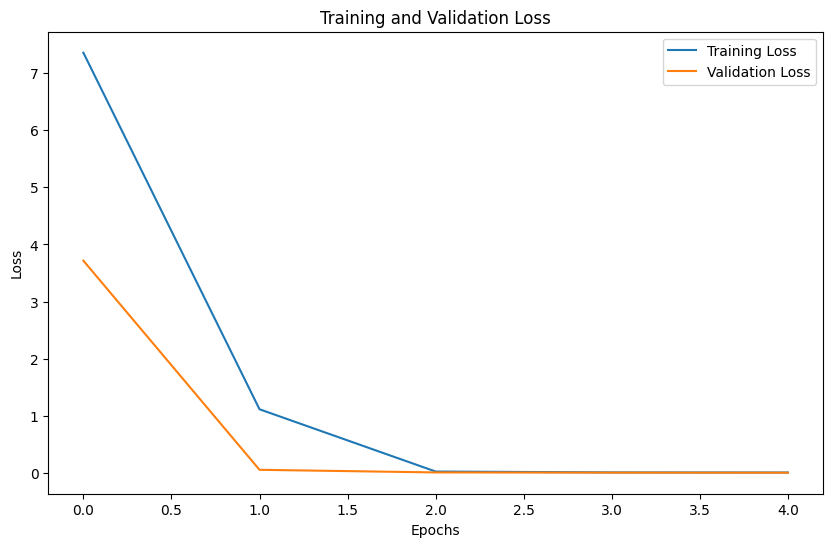

In [68]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [69]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use model to predict next token in sequence
    yhat = model.predict(sequence, verbose=0)

    # Get index of predicted word
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """

    return None


In [70]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    """
    # 1. Tokenize seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # 2. Pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    generated_text = seed_text  # Initialize with seed text

    for _ in range(max_sequence_len):
        # 3. Predict the next token
        predicted_index = get_predicted_word(model, token_list)

        # 4. Get the word for predicted index
        output_word = tokenizer.index_word[predicted_index] if predicted_index in tokenizer.index_word else "<OOV>"

        # 5. Update generated text and token list
        generated_text += " " + output_word
        token_list = np.append(token_list, [[predicted_index]], axis=1)
        token_list = token_list[:, 1:]  # Remove first token

    return generated_text # Return generated text

In [71]:
# Test text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [72]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-02 02:59:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.09MB/s    in 3m 17s  

2024-12-02 03:02:30 (4.18 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [73]:
# Load pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [74]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [75]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [76]:
# Define a new model and train it

# Your code here
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Preprocess the data
data = None # Load your data here
X, y = preprocess_data(data) # Replace with your preprocessing function
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

# Define new model with potential refinements
refined_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=SEQ_LENGTH), # Increased embedding dimension
    LSTM(units=256, return_sequences=True),  # Added another LSTM layer
    Dropout(0.2),  # Added dropout for regularization
    LSTM(units=256),
    Dense(units=VOCAB_SIZE, activation='softmax')
])

# Compile refined model
refined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train refined model
refined_history = refined_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val)) # Increased epochs


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.